##Graph Convolutional layer

In [ ]:
%pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html

import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim

from torch_geometric.utils import erdos_renyi_graph
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 7.9 MB 8.0 MB/s 
     |████████████████████████████████| 3.5 MB 69.8 MB/s 
     |████████████████████████████████| 2.4 MB 28.5 MB/s 
     |████████████████████████████████| 709 kB 17.6 MB/s 
     |████████████████████████████████| 467 kB 6.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.1.0.post1-py3-none-any.whl size=689859 sha256=fa3fb383e2419639339467c0528d46742aaf45b914b7b8d930a5e925e3fe3b6e
  Stored in directory: /root/.cache/pip/wheels/d1/cb/43/f7f2e472de4d7cff31bceddadc36d634e1e545fbc17961c282
Successfully built torch-geometric


In [ ]:
def get_edges(n_nodes):
    rows, cols = [], []
    for i in range(n_nodes):
        for j in range(n_nodes):
            if i != j:
                rows.append(i)
                cols.append(j)

    edges = [rows, cols]
    return edges
    
def get_edges_batch(n_nodes, batch_size):
    edges = get_edges(n_nodes)
    edge_attr = torch.ones(len(edges[0]) * batch_size, 1)
    edges = [torch.LongTensor(edges[0]), torch.LongTensor(edges[1])]
    if batch_size == 1:
        return edges, edge_attr
    elif batch_size > 1:
        rows, cols = [], []
        for i in range(batch_size):
            rows.append(edges[0] + n_nodes * i)
            cols.append(edges[1] + n_nodes * i)
        edges = [torch.cat(rows), torch.cat(cols)]
    return edges, edge_attr

In [ ]:
from torch import nn
import torch

class MLP(nn.Module):
    """ a simple 4-layer MLP """

    def __init__(self, nin, nout, nh):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(nin, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nh),
            nn.LeakyReLU(0.2),
            nn.Linear(nh, nout),
        )

    def forward(self, x):
        return self.net(x)

class GCL_basic(nn.Module):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self):
        super(GCL_basic, self).__init__()


    def edge_model(self, source, target, edge_attr):
        pass

    def node_model(self, h, edge_index, edge_attr):
        pass

    def forward(self, x, edge_index, edge_mask, edge_attr=None, node_attr=None):
        row, col = edge_index
        edge_feat = self.edge_model(x[row], x[col], edge_attr)
        edge_feat = edge_feat * edge_mask
        #print(x.shape)
        #print(node_attr.shape)

        x = self.node_model(x, edge_index, edge_feat, node_attr)
        return x, edge_feat

class GCL(GCL_basic):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, nodes_att_dim=0,  edges_in_nf=0, act_fn=nn.ReLU(), bias=True, attention=False, t_eq=False, recurrent=True):
        super(GCL, self).__init__()
        self.attention = attention
        self.t_eq=t_eq
        self.recurrent = recurrent
        input_edge_nf = input_nf * 2
        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge_nf + edges_in_nf, hidden_nf, bias=bias),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf, bias=bias),
            act_fn)
        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(input_nf, hidden_nf, bias=bias),
                act_fn,
                nn.Linear(hidden_nf, 1, bias=bias),
                nn.Sigmoid())


        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf, bias=bias),
            act_fn,
            nn.Linear(hidden_nf, output_nf, bias=bias))

        #if recurrent:
            #self.gru = nn.GRUCell(hidden_nf, hidden_nf)


    def edge_model(self, source, target, edge_attr):
        edge_in = torch.cat([source, target], dim=1)
        if edge_attr is not None:
            edge_in = torch.cat([edge_in, edge_attr], dim=1)
        out = self.edge_mlp(edge_in)
        if self.attention:
            att = self.att_mlp(torch.abs(source - target))
            out = out * att
        return out

    def node_model(self, h, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=h.size(0))
        if node_attr is not None:
            out = torch.cat([h, agg, node_attr], dim=1)
        else:
            out = torch.cat([h, agg], dim=1)

        out = self.node_mlp(out)
        if self.recurrent:
            out = out + h
            #out = self.gru(out, h)
        return out


def unsorted_segment_sum(data, segment_ids, num_segments):
    """Custom PyTorch op to replicate TensorFlow's `unsorted_segment_sum`."""
    result_shape = (num_segments, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result.scatter_add_(0, segment_ids, data)
    return result


def unsorted_segment_mean(data, segment_ids, num_segments):
    result_shape = (num_segments, data.size(1))
    segment_ids = segment_ids.unsqueeze(-1).expand(-1, data.size(1))
    result = data.new_full(result_shape, 0)  # Init empty result tensor.
    count = data.new_full(result_shape, 0)
    result.scatter_add_(0, segment_ids, data)
    count.scatter_add_(0, segment_ids, torch.ones_like(data))
    return result / count.clamp(min=1)




In [ ]:

def generate_edge_mask(batch_size, num_nodes, nodes_list, batch_edge_index):
  n = num_nodes
  edge_mask = [0] * n * (n-1) * batch_size
  for b in range(batch_size):
    for i in nodes_list:
      for j in nodes_list:
        for k in  range(batch_edge_index[b].shape[1]):
          if i == int(batch_edge_index[b][0,k]) and j == int(batch_edge_index[b][1,k]):
            if j < i:
              edge_mask[b * n * (n-1) + i*(n - 1) + j] = 1
            if j > i:
              edge_mask[b * n * (n-1) + i*(n - 1) + j - 1] = 1
  return edge_mask

In [ ]:
def get_graph_batch(batch_size, n_nodes, p):
  nodes_list = list(range(n_nodes))
  
  edges, edge_attr = get_edges_batch(n_nodes, batch_size)
  batch_edge_index = []
  adj_list = []
  for i in range(batch_size):
    edge_index = erdos_renyi_graph(n_nodes,p)
    batch_edge_index.append(edge_index)
    x = torch.tensor([[1]]*n_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index.contiguous())
    G = to_networkx(data)
    adj = np.array(nx.linalg.graphmatrix.adjacency_matrix(G).todense())
    adj_list.append(adj)
  edge_mask = generate_edge_mask(batch_size, n_nodes, nodes_list, batch_edge_index)
  tensor_edge_mask = torch.tensor(edge_mask, dtype=torch.float32).reshape(-1,1)
  return edges, edge_attr, tensor_edge_mask, adj_list



In [ ]:
input_nf, output_nf, hidden_nf, coords = 5, 1, 24, 3

gcl_layer = GCL(input_nf + coords, output_nf, hidden_nf)

In [ ]:
batch_size = 5
n_nodes = 6
p = 0.5
coord_dim = 3
edges, edge_attr, tensor_edge_mask,adj_list = get_graph_batch(batch_size, n_nodes, p)
feat = torch.ones(batch_size * n_nodes, input_nf)
coord = torch.rand(batch_size * n_nodes, coord_dim)
x = torch.cat([feat, coord], axis=1)

In [ ]:
h, edge_feat = gcl_layer(x = x, edge_index = edges, edge_mask = tensor_edge_mask)

In [ ]:
h.shape

torch.Size([30, 8])

###Overfit

In [ ]:
#Train:
input_nf, output_nf, hidden_nf, coords = 5, 1, 24, 3
optimizer_gcl = optim.Adam(gcl_layer.parameters(), lr=0.0001)
loss_l1_gcl = nn.L1Loss()
max_epoch = 4000
batch_size = 32
n_nodes = 6
p = 0.5
coord_dim = 3
l = 2.5
label = torch.full((batch_size * n_nodes, input_nf + coords), l)

for i in range(max_epoch):
  edges, edge_attr, tensor_edge_mask, adj_list = get_graph_batch(batch_size, n_nodes, p)
  feat = torch.ones(batch_size * n_nodes, input_nf)
  coord = torch.rand(batch_size * n_nodes, coord_dim)
  x = torch.cat([feat, coord], axis=1)
  h_1, _ = gcl_layer(x = x, edge_index = edges, edge_mask = tensor_edge_mask)
  loss = loss_l1_gcl(h_1, label)
  loss.backward()
  optimizer_gcl.step()
  if i % 50 == 0:
    print("Epoch: {}, MSE: {:.4f}".format((i+1), loss))
    

Epoch: 1, MSE: 1.8206
Epoch: 51, MSE: 1.5767
Epoch: 101, MSE: 1.2617
Epoch: 151, MSE: 0.8207
Epoch: 201, MSE: 0.5755
Epoch: 251, MSE: 0.8903
Epoch: 301, MSE: 0.7147
Epoch: 351, MSE: 0.5896
Epoch: 401, MSE: 0.4579
Epoch: 451, MSE: 0.4805
Epoch: 501, MSE: 0.4784
Epoch: 551, MSE: 0.5015
Epoch: 601, MSE: 0.3787
Epoch: 651, MSE: 0.3392
Epoch: 701, MSE: 0.3768
Epoch: 751, MSE: 0.4004
Epoch: 801, MSE: 0.4146
Epoch: 851, MSE: 0.3529
Epoch: 901, MSE: 0.2795
Epoch: 951, MSE: 0.2358
Epoch: 1001, MSE: 0.2520
Epoch: 1051, MSE: 0.2597
Epoch: 1101, MSE: 0.2340
Epoch: 1151, MSE: 0.2291
Epoch: 1201, MSE: 0.2492
Epoch: 1251, MSE: 0.2647
Epoch: 1301, MSE: 0.2604
Epoch: 1351, MSE: 0.2386
Epoch: 1401, MSE: 0.2294
Epoch: 1451, MSE: 0.2556
Epoch: 1501, MSE: 0.2822
Epoch: 1551, MSE: 0.2242
Epoch: 1601, MSE: 0.2366
Epoch: 1651, MSE: 0.2711
Epoch: 1701, MSE: 0.2854
Epoch: 1751, MSE: 0.2642
Epoch: 1801, MSE: 0.2211
Epoch: 1851, MSE: 0.2362
Epoch: 1901, MSE: 0.3120
Epoch: 1951, MSE: 0.2467
Epoch: 2001, MSE: 0.224

In [ ]:
edges, edge_attr, tensor_edge_mask, adj_list = get_graph_batch(batch_size, n_nodes, p)
feat = torch.ones(batch_size * n_nodes, input_nf)
coord = torch.rand(batch_size * n_nodes, coord_dim)
x = torch.cat([feat, coord], axis=1)
h_1, _ = gcl_layer(x = x, edge_index = edges, edge_mask = tensor_edge_mask)


In [ ]:
edges[0]

tensor([  0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   2,   2,   2,   2,
          2,   3,   3,   3,   3,   3,   4,   4,   4,   4,   4,   5,   5,   5,
          5,   5,   6,   6,   6,   6,   6,   7,   7,   7,   7,   7,   8,   8,
          8,   8,   8,   9,   9,   9,   9,   9,  10,  10,  10,  10,  10,  11,
         11,  11,  11,  11,  12,  12,  12,  12,  12,  13,  13,  13,  13,  13,
         14,  14,  14,  14,  14,  15,  15,  15,  15,  15,  16,  16,  16,  16,
         16,  17,  17,  17,  17,  17,  18,  18,  18,  18,  18,  19,  19,  19,
         19,  19,  20,  20,  20,  20,  20,  21,  21,  21,  21,  21,  22,  22,
         22,  22,  22,  23,  23,  23,  23,  23,  24,  24,  24,  24,  24,  25,
         25,  25,  25,  25,  26,  26,  26,  26,  26,  27,  27,  27,  27,  27,
         28,  28,  28,  28,  28,  29,  29,  29,  29,  29,  30,  30,  30,  30,
         30,  31,  31,  31,  31,  31,  32,  32,  32,  32,  32,  33,  33,  33,
         33,  33,  34,  34,  34,  34,  34,  35,  35,  35,  35,  

In [ ]:
edge_attr.shape

torch.Size([960, 1])

###MPNN

In [ ]:
class MPNN(nn.Module):
  def __init__(self, in_node_nf, coords, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, coords_weight=1.0, attention=False, node_attr=1):
      super(MPNN, self).__init__()
      self.hidden_nf = hidden_nf
      self.device = device
      self.n_layers = n_layers
      ### Encoder
      self.embedding = nn.Linear(in_node_nf + coords, hidden_nf)
      self.node_attr = node_attr
      if node_attr:
          n_node_attr = in_node_nf + coords
      else:
          n_node_attr = 0
      for i in range(0, n_layers):
          self.add_module("gcl_%d" % i, GCL(self.hidden_nf, self.hidden_nf, self.hidden_nf, nodes_att_dim=n_node_attr))

      self.node_dec = nn.Sequential(nn.Linear(self.hidden_nf, self.hidden_nf),
                                    act_fn,
                                    nn.Linear(self.hidden_nf, 1 + coords))

      self.to(self.device)

  def forward(self, x, edges, edge_attr, edge_mask, n_nodes):
    h = self.embedding(x)
    for i in range(0, self.n_layers):
        if self.node_attr:
            h, _ = self._modules["gcl_%d" % i](h, edges, edge_mask, edge_attr=None, node_attr = x)
        else:
            h, _ = self._modules["gcl_%d" % i](x, edge_index, edge_mask, edge_attr=None, node_attr=None)

    pred = self.node_dec(h)
    return pred.squeeze(1)


In [ ]:
input_nf, output_nf, hidden_nf, coords = 5, 1, 24, 3
mpnn = MPNN(in_node_nf=input_nf, coords=coords, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)

In [ ]:
batch_size = 5
n_nodes = 6
p = 0.5
edges, edge_attr, tensor_edge_mask = get_graph_batch(batch_size, n_nodes, p)
feat = torch.ones(batch_size * n_nodes, input_nf)
coord = torch.rand(batch_size * n_nodes, coords)
x = torch.cat([feat, coord], axis=1)
h = mpnn(x, edges, edge_attr, tensor_edge_mask, n_nodes)

ValueError: ignored

In [ ]:
input_nf, output_nf, hidden_nf, coords = 5, 1, 24, 3
max_epoch = 4000
batch_size = 32
n_nodes = 6
p = 0.5
coord_dim = 3
l = 2.5
label = torch.full((batch_size * n_nodes, hidden_nf), l)
mpnn = MPNN(in_node_nf=input_nf, coords=coords, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)
optimizer_mpnn = optim.Adam(mpnn.parameters(), lr=0.0001)
loss_l1_mpnn = nn.L1Loss()


for i in range(max_epoch):
  edges, edge_attr, tensor_edge_mask = get_graph_batch(batch_size, n_nodes, p)
  feat = torch.ones(batch_size * n_nodes, input_nf)
  coord = torch.rand(batch_size * n_nodes, coords)
  x = torch.cat([feat, coord], axis=1)
  h_1 = mpnn(x, edges, edge_attr, tensor_edge_mask, n_nodes)
  loss = loss_l1_mpnn(h_1, label)
  loss.backward()
  optimizer_mpnn.step()
  if i % 50 == 0:
    print("Epoch: {}, MSE: {:.4f}".format((i+1), loss))
    

In [ ]:
edges, edge_attr, tensor_edge_mask = get_graph_batch(batch_size, n_nodes, p)
feat = torch.ones(batch_size * n_nodes, input_nf)
coord = torch.rand(batch_size * n_nodes, coords)
x = torch.cat([feat, coord], axis=1)
h = mpnn(x, edges, edge_attr, tensor_edge_mask, n_nodes)

##Equivariant Graph Convolutional Layer

In [ ]:
#Layers :

class E_GCL(nn.Module):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_att_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False, clamp=False, norm_diff=False, tanh=False):
        super(E_GCL, self).__init__()
        input_edge = input_nf * 2
        self.coords_weight = coords_weight
        self.recurrent = recurrent
        self.attention = attention
        self.norm_diff = norm_diff
        self.tanh = tanh
        edge_coords_nf = 1

        #print(hidden_nf)
        #print(input_nf)
        #print(nodes_att_dim)


        self.edge_mlp = nn.Sequential(
            nn.Linear(input_edge + edge_coords_nf + edges_in_d, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, hidden_nf),
            act_fn)

        self.node_mlp = nn.Sequential(
            nn.Linear(hidden_nf + input_nf + nodes_att_dim, hidden_nf),
            act_fn,
            nn.Linear(hidden_nf, output_nf))

        layer = nn.Linear(hidden_nf, 1, bias=False)
        torch.nn.init.xavier_uniform_(layer.weight, gain=0.001)

        self.clamp = clamp
        coord_mlp = []
        coord_mlp.append(nn.Linear(hidden_nf, hidden_nf))
        coord_mlp.append(act_fn)
        coord_mlp.append(layer)
        if self.tanh:
            coord_mlp.append(nn.Tanh())
            self.coords_range = nn.Parameter(torch.ones(1))*3
        self.coord_mlp = nn.Sequential(*coord_mlp)


        if self.attention:
            self.att_mlp = nn.Sequential(
                nn.Linear(hidden_nf, 1),
                nn.Sigmoid())

        #if recurrent:
        #    self.gru = nn.GRUCell(hidden_nf, hidden_nf)


    def edge_model(self, source, target, radial, edge_attr):
        if edge_attr is None:  # Unused.
            out = torch.cat([source, target, radial], dim=1)
        else:
            out = torch.cat([source, target, radial, edge_attr], dim=1)
        out = self.edge_mlp(out)
        if self.attention:
            att_val = self.att_mlp(out)
            out = out * att_val
        return out

    def node_model(self, x, edge_index, edge_attr, node_attr):
        row, col = edge_index
        agg = unsorted_segment_sum(edge_attr, row, num_segments=x.size(0))
        if node_attr is not None:
            agg = torch.cat([x, agg, node_attr], dim=1)
        else:
            agg = torch.cat([x, agg], dim=1)
        #print(type(node_attr))
        #print(x.shape)
        #print(agg.shape)
        #print(node_attr.shape)
        out = self.node_mlp(agg)
        if self.recurrent:
            out = x + out
        return out, agg

    def coord_model(self, coord, edge_index, coord_diff, edge_feat):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat)
        trans = torch.clamp(trans, min=-100, max=100) #This is never activated but just in case it case it explosed it may save the train
        agg = unsorted_segment_mean(trans, row, num_segments=coord.size(0))
        coord += agg*self.coords_weight
        return coord


    def coord2radial(self, edge_index, coord):
        row, col = edge_index
        coord_diff = coord[row] - coord[col]
        #print(coord_diff)
        radial = torch.sum((coord_diff)**2, 1).unsqueeze(1)
        #print(radial)
        if self.norm_diff:
            norm = torch.sqrt(radial) + 1
            coord_diff = coord_diff/(norm)

        return radial, coord_diff

    def forward(self, h, edge_index, coord, edge_attr=None, node_attr=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)

        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)
        coord = self.coord_model(coord, edge_index, coord_diff, edge_feat)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)
        # coord = self.node_coord_model(h, coord)
        # x = self.node_model(x, edge_index, x[col], u, batch)  # GCN
        return h, coord, edge_attr


In [ ]:
class E_GCL_mask(E_GCL):
    """Graph Neural Net with global state and fixed number of nodes per graph.
    Args:
          hidden_dim: Number of hidden units.
          num_nodes: Maximum number of nodes (for self-attentive pooling).
          global_agg: Global aggregation function ('attn' or 'sum').
          temp: Softmax temperature.
    """

    def __init__(self, input_nf, output_nf, hidden_nf, edges_in_d=0, nodes_attr_dim=0, act_fn=nn.ReLU(), recurrent=True, coords_weight=1.0, attention=False):
        E_GCL.__init__(self, input_nf, output_nf, hidden_nf, edges_in_d=edges_in_d, nodes_att_dim=nodes_attr_dim, act_fn=act_fn, recurrent=recurrent, coords_weight=coords_weight, attention=attention)

        del self.coord_mlp
        self.act_fn = act_fn

    def coord_model(self, coord, edge_index, coord_diff, edge_feat, edge_mask):
        row, col = edge_index
        trans = coord_diff * self.coord_mlp(edge_feat) * edge_mask
        agg = unsorted_segment_sum(trans, row, num_segments=coord.size(0))
        coord += agg*self.coords_weight
        return coord

    def forward(self, h, edge_index, coord, edge_mask, edge_attr=None, node_attr=None, n_nodes=None):
        row, col = edge_index
        radial, coord_diff = self.coord2radial(edge_index, coord)
        edge_feat = self.edge_model(h[row], h[col], radial, edge_attr)

        edge_feat = edge_feat * edge_mask

        # TO DO: edge_feat = edge_feat * edge_mask

        #coord = self.coord_model(coord, edge_index, coord_diff, edge_feat, edge_mask)
        h, agg = self.node_model(h, edge_index, edge_feat, node_attr)

        return h, coord, edge_attr

In [ ]:
def visualize(h, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                          cmap="Set2")
    plt.show()

In [ ]:
input_nf, output_nf, hidden_nf = 5, 1, 24

e_gcl_layer = E_GCL_mask(input_nf, output_nf, hidden_nf)

In [ ]:
batch_size = 1
n_nodes = 4
p = 1
coord_dim = 3
edges, edge_attr, tensor_edge_mask, adj_list = get_graph_batch(batch_size, n_nodes, p)
feat = torch.ones(batch_size * n_nodes, input_nf)
#x = torch.rand(batch_size * n_nodes, coord_dim)
x = torch.tensor([[0,0,0],[1,0,0],[0,1,0],[1,1,0]])

In [ ]:
edges[0].shape

torch.Size([12])

In [ ]:
h, x, edge_attr = e_gcl_layer(feat, edges, x, tensor_edge_mask)

In [ ]:
h.shape

###Overfit

In [ ]:
#Train:
from torch import nn, optim
optimizer = optim.Adam(e_gcl_layer.parameters(), lr=0.0001)
loss_l1 = nn.L1Loss()
max_epoch = 4000
batch_size = 32
n_nodes = 6
p = 0.5
coord_dim = 3
l = 2.5
label = torch.full((batch_size * n_nodes, input_nf), l)

for i in range(max_epoch):
  edges, edge_attr, tensor_edge_mask, adj_list = get_graph_batch(batch_size, n_nodes, p)
  feat = torch.ones(batch_size * n_nodes, input_nf)
  x = torch.rand(batch_size * n_nodes, coord_dim)
  h_1, _, _ = e_gcl_layer(feat, edges, x, tensor_edge_mask)
  loss = loss_l1(h_1, label)
  loss.backward()
  optimizer.step()
  if i % 50 == 0:
    print("Epoch: {}, MSE: {:.4f}".format((i+1), loss))
    

Epoch: 1, MSE: 1.6456
Epoch: 51, MSE: 1.5301
Epoch: 101, MSE: 1.3233
Epoch: 151, MSE: 1.0562
Epoch: 201, MSE: 0.6513
Epoch: 251, MSE: 0.4786
Epoch: 301, MSE: 0.6678
Epoch: 351, MSE: 0.7434
Epoch: 401, MSE: 0.4029
Epoch: 451, MSE: 0.3686
Epoch: 501, MSE: 0.4575
Epoch: 551, MSE: 0.4764
Epoch: 601, MSE: 0.3027
Epoch: 651, MSE: 0.1754
Epoch: 701, MSE: 0.3022
Epoch: 751, MSE: 0.3572
Epoch: 801, MSE: 0.3375
Epoch: 851, MSE: 0.2134
Epoch: 901, MSE: 0.1066
Epoch: 951, MSE: 0.0991
Epoch: 1001, MSE: 0.1458
Epoch: 1051, MSE: 0.1267
Epoch: 1101, MSE: 0.0558
Epoch: 1151, MSE: 0.0577
Epoch: 1201, MSE: 0.1428
Epoch: 1251, MSE: 0.1824
Epoch: 1301, MSE: 0.1699
Epoch: 1351, MSE: 0.1099
Epoch: 1401, MSE: 0.0079
Epoch: 1451, MSE: 0.0995
Epoch: 1501, MSE: 0.1623
Epoch: 1551, MSE: 0.1869
Epoch: 1601, MSE: 0.1657
Epoch: 1651, MSE: 0.0932
Epoch: 1701, MSE: 0.0270
Epoch: 1751, MSE: 0.1410
Epoch: 1801, MSE: 0.1918
Epoch: 1851, MSE: 0.1881
Epoch: 1901, MSE: 0.1315
Epoch: 1951, MSE: 0.0262
Epoch: 2001, MSE: 0.098

In [ ]:
edges, edge_attr, tensor_edge_mask = get_graph_batch(batch_size, n_nodes, p)
feat = torch.ones(batch_size * n_nodes, input_nf)
x = torch.rand(batch_size * n_nodes, coord_dim)
h_1, _, _ = e_gcl_layer(feat, edges, x, tensor_edge_mask)

In [ ]:
h_1

###EGNN

In [ ]:
class EGNN(nn.Module):
    def __init__(self, in_node_nf, in_edge_nf, hidden_nf, device='cpu', act_fn=nn.SiLU(), n_layers=4, coords_weight=1.0, attention=False, node_attr=1):
        super(EGNN, self).__init__()
        self.hidden_nf = hidden_nf
        self.device = device
        self.n_layers = n_layers

        ### Encoder
        self.embedding = nn.Linear(in_node_nf, hidden_nf)
        self.node_attr = node_attr
        if node_attr:
            n_node_attr = in_node_nf
        else:
            n_node_attr = 0
        for i in range(0, n_layers):
            self.add_module("gcl_%d" % i, E_GCL_mask(self.hidden_nf, self.hidden_nf, self.hidden_nf, edges_in_d=in_edge_nf, nodes_attr_dim=n_node_attr, act_fn=act_fn, recurrent=True, coords_weight=coords_weight, attention=attention))

        self.node_dec = nn.Sequential(nn.Linear(self.hidden_nf, self.hidden_nf),
                                      act_fn,
                                      nn.Linear(self.hidden_nf, 1))

        self.graph_dec = nn.Sequential(nn.Linear(self.hidden_nf, self.hidden_nf),
                                       act_fn,
                                       nn.Linear(self.hidden_nf, 1))
        self.to(self.device)

    def forward(self, h0, x, edges, edge_attr, edge_mask, n_nodes):
        h = self.embedding(h0)
        for i in range(0, self.n_layers):
            if self.node_attr:
                h, x, _ = self._modules["gcl_%d" % i](h, edges, x, edge_mask, edge_attr=edge_attr, node_attr=h0, n_nodes=n_nodes)
            else:
                h, x, _ = self._modules["gcl_%d" % i](h, edges, x, edge_mask, edge_attr=edge_attr,
                                                      node_attr=None, n_nodes=n_nodes)

        pred = self.node_dec(h)
        return pred.squeeze(1).reshape(-1,1), x


In [ ]:
input_nf, output_nf, hidden_nf = 5, 1, 24

egnn = EGNN(in_node_nf=input_nf, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)

In [ ]:
n_nodes = 6
p = 0.5
coord_dim = 3
batch_size = 32
l = 2.5
edges, edge_attr, tensor_edge_mask, adj_list = get_graph_batch(batch_size, n_nodes, p)
feat = torch.ones(batch_size * n_nodes, input_nf)
x = torch.rand(batch_size * n_nodes, coord_dim)
h = egnn(feat, x, edges, edge_attr, tensor_edge_mask, n_nodes)

In [ ]:
h[0].shape

In [ ]:
input_nf, output_nf, hidden_nf = 5, 1, 24
max_epoch = 4000
batch_size = 32
n_nodes = 6
p = 0.5
coord_dim = 3
l = 2.5
label = torch.full((batch_size * n_nodes, hidden_nf), l)
egnn = EGNN(in_node_nf=input_nf, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)
optimizer_egnn = optim.Adam(egnn.parameters(), lr=0.0001)
loss_l1_egnn = nn.L1Loss()


for i in range(max_epoch):
  edges, edge_attr, tensor_edge_mask = get_graph_batch(batch_size, n_nodes, p)
  feat = torch.ones(batch_size * n_nodes, input_nf)
  x = torch.rand(batch_size * n_nodes, coord_dim)
  h_1 = egnn(feat, x, edges, edge_attr, tensor_edge_mask, n_nodes)
  loss = loss_l1_egnn(h_1, label)
  loss.backward()
  optimizer_egnn.step()
  if i % 50 == 0:
    print("Epoch: {}, MSE: {:.4f}".format((i+1), loss))
    

NameError: ignored

In [ ]:
edges, edge_attr, tensor_edge_mask = get_graph_batch(batch_size, n_nodes, p)
feat = torch.rand(batch_size * n_nodes, input_nf)
x = torch.rand(batch_size * n_nodes, coord_dim)
h_1 = egnn(feat, x, edges, edge_attr, tensor_edge_mask, n_nodes)

In [ ]:
h_1

## Generate Labels

In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
class LabelGenerate():
  def __init__(self, x, h, edges, edge_attr, batch_size, n_nodes, graphs):
    # Returns (x', h'), where x' is invariant to E(n), and h' is equivariant to E(n)
    #x' = x + g(x,h,G) = x + p(h)* A * phi(x) * f_1(x)
    #h = p(h) * A * f_2(x)


    self.x = x
    self.h = h
    self.edges = edges
    self.edge_attr = edge_attr
    self.batch_size = batch_size
    self.n = n_nodes
    self.graphs = graphs
    #self.W = 

  def x_1(self, feat):
    dmatrix = np.empty(shape=(self.batch_size , self.n, self.x.shape[1]))
    c=0
    for i in range(0, self.x.shape[0], self.n):

      g = self.graphs[c]
      graph = self.x[i:i+self.n]
      s = graph[:, :, None] - graph[:, :, None].T
      s_swap = np.array(np.swapaxes(s, 1, 2))
      #f_x = (np.array(feat[i:i+self.n].sum(1)).reshape((self.n, 1, 1)) * s_swap * g.reshape((self.n,self.n,1))).sum(1)
      f_x = (np.array(feat[i:i+self.n].sum(1)).reshape((self.n, 1, 1)) * s_swap ).sum(1)
      dmatrix[c] = f_x
      c+=1

    return self.x + dmatrix.reshape(-1, dmatrix.shape[2])

    

  def h_1(self, feat, type_f2 = 'distance'):

    if type_f2 == 'volume':
    
      volume = np.empty(shape = (self.batch_size, self.n, 1))
      ones = np.ones(shape = (self.n, 1))
      c = 0
      for i in range(0, self.x.shape[0], self.n):
        g = self.graphs[c]
        coords = self.x[i:i+self.n]
        #print(coords)
        vol = ConvexHull(coords).volume
        vol_array = ones * np.array(vol)
        f_2x = np.array((feat[i:i+self.n].sum(1) * g @ vol_array))
        volume[c] = f_2x
        c+=1
      h_1 = volume

    elif type_f2 == 'area':

      area = np.empty(shape = (self.batch_size, self.n, 1))
      ones = np.ones(shape = (self.n, 1))
      c = 0
      for i in range(0, self.x.shape[0], self.n):
        g = self.graphs[c]
        coords = self.x[i:i+self.n]
        #print(coords)
        area_coord = ConvexHull(coords).area
        area_array = ones * np.array(area_coord)
        f_2x = np.array((feat[i:i+self.n].sum(1) * g @ area_array))
        area[c] = f_2x
        c+=1
      h_1 = area

    elif type_f2 == 'distance':
      
      dist = np.empty(shape = (self.batch_size, self.n, 1))
      c = 0
      
      for i in range(0, self.x.shape[0], self.n):
        g = self.graphs[c]
        coords = self.x[i:i+self.n]
        d = squareform(pdist(coords))
        f_2x = (g * d * np.array(feat[i:i+self.n].sum(1))).sum(1)
        dist[c] = f_2x.reshape(-1, 1)
        c+=1
        
      h_1 = dist

    elif type_f2 == 'angles':
      angles = np.empty(shape = (self.batch_size, self.n, 1))
      c = 0
      for i in range(0, self.x.shape[0], self.n):
        g = self.graphs[c]
        coords = self.x[i:i+self.n]
        d = np.zeros((self.n, self.n))
        for i in range(self.n):
          for j in range(self.n):
            v = coords[i,:]
            w = coords[j,:]
            angle_ij = np.arccos(v.dot(w)/(np.linalg.norm(v)*np.linalg.norm(w)))
            d[i,j] = angle_ij
        d = squareform(pdist(coords))
        f_2x = (g * d * np.array(feat[i:i+self.n].sum(1))).sum(1)
        angles[c] = f_2x.reshape(-1, 1)
        c+=1
      h_1 = angles

    return h_1.reshape(-1, h_1.shape[2])



  def p(self):
    #simply exponential
    #return np.exp(self.h)
    return self.h
    #return np.ones(shape=self.h.shape)

  def get_labels(self, type_f2 = 'distance'):

    p = self.p()
    x_1 = self.x_1(p)
    h_1 = self.h_1(p, type_f2)
    #Standard Normalization
    #print(type(x_1))
    #x_1 = (x_1 - torch.mean(x_1))/torch.std(x_1)
    #h_1 = (h_1 - np.mean(h_1))/np.std(h_1)
    #Frobenius Normalization
    return x_1, h_1

In [ ]:
p=0.5
graphs = []
for i in range(batch_size):
  G = nx.erdos_renyi_graph(n_nodes, p)
  adj = np.array(nx.linalg.graphmatrix.adjacency_matrix(G).todense())
  graphs.append(adj)

In [ ]:
l_gen = LabelGenerate(x, h, edges, edge_attr, batch_size, n_nodes, graphs)

In [ ]:
l_gen_2 = LabelGenerate(x + np.array([1,1,1]), h, edges, edge_attr, batch_size, n_nodes, graphs)

In [ ]:
x_2, h_2 =  l_gen.get_labels(type_f2 = 'distance')

ValueError: ignored

In [ ]:
x_3, h_3 =  l_gen_2.get_labels(type_f2 = 'distance')

In [ ]:
np.linalg.norm(h_3 - h_2)

0.0

In [ ]:
x_3 - x_2

tensor([[1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000],
        [1.000

In [ ]:
h_2

array([[0.07743948],
       [0.02725298],
       [0.10319543],
       [0.07248706],
       [0.13208133],
       [0.05677085],
       [0.08703128],
       [0.08808563],
       [0.06125402],
       [0.09030158],
       [0.07095722],
       [0.15491455],
       [0.09135788],
       [0.10850103],
       [0.        ],
       [0.103842  ],
       [0.10191548],
       [0.06669638],
       [0.09313365],
       [0.10901485],
       [0.06001022],
       [0.11550358],
       [0.08351206],
       [0.0555909 ],
       [0.11122989],
       [0.10611257],
       [0.08184737],
       [0.03302928],
       [0.02202014],
       [0.02761344],
       [0.0953065 ],
       [0.07613777],
       [0.07389257],
       [0.10747883],
       [0.0649263 ],
       [0.03969524]])

##Experiment 1:

In [ ]:
#Fixed Graph and Node Features: 
#Vary Label Functions. Try to find Equivariant Labels that EGNN can't learn by MPNN does.

In [ ]:
torch.normal(mean= 0.5, std=0.1, size=(3,1))

tensor([[0.5105],
        [0.3904],
        [0.5372]])

In [ ]:
#GENERATE DATASET:

#Generate a graph:
n_nodes = 6
p = 0.5
edges, edge_attr, tensor_edge_mask, adj_list = get_graph_batch(1, n_nodes, p)
input_nf, output_nf, hidden_nf, coords = 5, 1, 24, 3
mu, sigma = 0,1

#Dataset(Train-Val-Test)

#Train:

training_set_size = 10000
adj_list_tr = adj_list * training_set_size
edges_0_tr = torch.cat([edges[0]] * training_set_size)
edges_1_tr = torch.cat([edges[1]] * training_set_size)
edges_tr = [edges_0_tr, edges_1_tr]
edge_attr_tr = torch.cat([edge_attr] * training_set_size)
tensor_edge_mask_tr = torch.cat([tensor_edge_mask] * training_set_size)

#Generare Node Features and Coordinates
feat_tr = torch.ones(training_set_size * n_nodes, input_nf)
coord_tr = torch.normal(mean=mu,std=sigma,size=(training_set_size * n_nodes, coords))

#Val:
validation_set_size = 500
adj_list_val = adj_list * validation_set_size
edges_0_val = torch.cat([edges[0]] * validation_set_size)
edges_1_val = torch.cat([edges[1]] * validation_set_size)
edges_val = [edges_0_val, edges_1_val]
edge_attr_val = torch.cat([edge_attr] * validation_set_size)
tensor_edge_mask_val = torch.cat([tensor_edge_mask] * validation_set_size)

#Generare Node Features and Coordinates
feat_val = torch.ones(validation_set_size * n_nodes, input_nf)
coord_val = torch.normal(mean=mu,std=sigma,size=(validation_set_size * n_nodes, coords))

#Test:
test_set_size = 500
adj_list_test = adj_list * test_set_size
edges_0_test = torch.cat([edges[0]] * test_set_size)
edges_1_test = torch.cat([edges[1]] * test_set_size)
edges_test = [edges_0_test, edges_1_test]
edge_attr_test = torch.cat([edge_attr] * test_set_size)
tensor_edge_mask_test = torch.cat([tensor_edge_mask] * test_set_size)

#Generare Node Features and Coordinates
feat_test = torch.ones(test_set_size * n_nodes, input_nf)
coord_test = torch.normal(mean=mu,std=sigma,size=(test_set_size * n_nodes, coords))

#Generate Labels: Training Set
l_gen_tr = LabelGenerate(coord_tr, feat_tr, edges_tr, edge_attr_tr, training_set_size, n_nodes, adj_list_tr)
x_tr, h_tr =  l_gen_tr.get_labels(type_f2 = 'distance')
#Generate Labels: Validation Set
l_gen_val = LabelGenerate(coord_val, feat_val, edges_val, edge_attr_val, validation_set_size, n_nodes, adj_list_val)
x_val, h_val =  l_gen_val.get_labels(type_f2 = 'distance')
#Generate Labels: Test Set
l_gen_test = LabelGenerate(coord_test, feat_test, edges_test, edge_attr_test, test_set_size, n_nodes, adj_list_test)
x_test, h_test =  l_gen_test.get_labels(type_f2 = 'distance')


In [ ]:
#Shuffle Training Set
def shuffle(adj_list, edges_0, edges_1, edge_attr, tensor_edge_mask, feat, coord, x_label, h_label, training_set_size, n_nodes):
  perm = np.random.permutation(training_set_size)
  adj_list = [adj_list[i] for i in perm]
  feat = torch.cat([feat[n_nodes*i:n_nodes*i + n_nodes, :] for i in perm])
  coord = torch.cat([coord[n_nodes*i:n_nodes*i + n_nodes, :] for i in perm])
  tensor_edge_mask = torch.cat([tensor_edge_mask[n_nodes*(n_nodes-1)*i:n_nodes*(n_nodes-1)*i + n_nodes*(n_nodes-1), :] for i in perm])
  edge_attr = torch.cat([edge_attr[n_nodes*(n_nodes-1)*i:n_nodes*(n_nodes-1)*i + n_nodes*(n_nodes-1), :] for i in perm])
  edges_0 = torch.cat([edges_0[n_nodes*(n_nodes-1)*i:n_nodes*(n_nodes-1)*i + n_nodes*(n_nodes-1)] for i in perm])
  edges_1 = torch.cat([edges_1[n_nodes*(n_nodes-1)*i:n_nodes*(n_nodes-1)*i + n_nodes*(n_nodes-1)] for i in perm])
  edges = [edges_0, edges_1]
  x_label = torch.cat([x_label[n_nodes*i:n_nodes*i + n_nodes, :] for i in perm])
  h_label = np.concatenate([h_label[n_nodes*i:n_nodes*i + n_nodes, :] for i in perm])
  return adj_list, feat, coord, tensor_edge_mask, edge_attr, edges, x_label, h_label

In [ ]:
adj_list_tr, feat_tr, coord_tr, tensor_edge_mask_tr, edge_attr_tr, edges_tr, x_tr, h_tr = shuffle(adj_list_tr, 
                                                                                                  edges_0_tr, 
                                                                                                  edges_1_tr, 
                                                                                                  edge_attr_tr, 
                                                                                                  tensor_edge_mask_tr, 
                                                                                                  feat_tr, coord_tr, x_tr, h_tr,
                                                                                                  training_set_size, n_nodes)

In [ ]:
mpnn = MPNN(in_node_nf=input_nf, coords=coords, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)
egnn = EGNN(in_node_nf=input_nf, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)


In [ ]:
#Train
from torch import nn, optim

max_epoch = 1000
optimizer_mpnn = optim.Adam(mpnn.parameters(), lr=0.0001)
loss_l1_mpnn = nn.L1Loss()
optimizer_egnn = optim.Adam(egnn.parameters(), lr=0.0001)
loss_l1_egnn = nn.L1Loss()
batch_size = 100
iteration = training_set_size // batch_size

for i in range(max_epoch):
  """adj_list_tr, feat_tr, coord_tr, tensor_edge_mask_tr, edge_attr_tr, edges_tr, x_tr, h_tr = shuffle(adj_list_tr, 
                                                                                                    edges_0_tr, 
                                                                                                    edges_1_tr, 
                                                                                                    edge_attr_tr, 
                                                                                                    tensor_edge_mask_tr, 
                                                                                                    feat_tr, coord_tr, x_tr, h_tr,
                                                                                                    training_set_size, n_nodes)
  """
  for iters in range(iteration):
    #Each iteration is process #batch_size number of graphs

    coord = coord_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    feat = feat_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    x_1 = x_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    h_1 = h_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    h_1 = torch.tensor(h_1)
    edges_0 = edges_tr[0][iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1)]
    edges_1 = edges_tr[1][iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1)]
    edges = [edges_0, edges_1]
    
    edge_attr = edge_attr_tr[iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1),:]
    tensor_edge_mask = tensor_edge_mask_tr[iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1),:]
    x = torch.cat([feat, coord], axis=1)
    out_mpnn = mpnn(x, edges, edge_attr, tensor_edge_mask, n_nodes)
    #h_mpnn, x_mpnn = out_mpnn[:,0], out_mpnn[:,1:]
    h_egnn, x_egnn = egnn(feat, coord, edges, edge_attr, tensor_edge_mask, n_nodes)
    out_egnn = torch.cat([x_egnn, h_egnn],axis=1)
    label = torch.cat([x_1, h_1], axis=1)
    loss_mpnn = loss_l1_mpnn(out_mpnn, label)
    loss_egnn = loss_l1_egnn(out_egnn, label)
    loss_mpnn.backward()
    loss_egnn.backward()
    optimizer_mpnn.step()
    optimizer_egnn.step()
    if iters % 50 == 0:
      print("Epoch: {}, Iteration: {}, MPNN MSE: {:.4f}, EGNN MSE: {:.4f}".format((i+1), iters, loss_mpnn, loss_egnn))
      


Epoch: 1, Iteration: 0, MPNN MSE: 24.3746, EGNN MSE: 23.7716
Epoch: 1, Iteration: 50, MPNN MSE: 24.9609, EGNN MSE: 24.4464
Epoch: 2, Iteration: 0, MPNN MSE: 24.0601, EGNN MSE: 23.5729
Epoch: 2, Iteration: 50, MPNN MSE: 24.7330, EGNN MSE: 24.2888
Epoch: 3, Iteration: 0, MPNN MSE: 23.7164, EGNN MSE: 23.3453
Epoch: 3, Iteration: 50, MPNN MSE: 24.1838, EGNN MSE: 23.8147


KeyboardInterrupt: ignored

In [ ]:
print(edges_0.shape)

torch.Size([3000])


In [ ]:
edges_0[:30]

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5])

In [ ]:
edges_1[:30]

tensor([1, 2, 3, 4, 5, 0, 2, 3, 4, 5, 0, 1, 3, 4, 5, 0, 1, 2, 4, 5, 0, 1, 2, 3,
        5, 0, 1, 2, 3, 4])

In [ ]:
adj_list[0]

array([[0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 0, 0],
       [1, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0]], dtype=int64)

In [ ]:
edges_tr[0].shape

torch.Size([300000])

In [ ]:
print(x.shape)

torch.Size([600, 8])


##Experiment 2:

In [ ]:
#2a) Fix Graph, Vary Random Node Features and X. 
#2b) Fix Random Node Features, Vary Graph and X
#2c) Fix X. Vary Random Node Features and Graph
# In which case is data efficiency helped the most. What is the effect of X on the label
# Does random node feature make sense?


##Experiment 3:

In [ ]:
# Vary G, Random Node Features and X. 
# Compare data efficiency of MPNN compared to Standard MPNN.

In [ ]:
#GENERATE DATASET:

n_nodes = 4
p = 0.5
input_nf, output_nf, hidden_nf, coords = 4, 1, 24, 3
mu_x, sigma_x, mu_h, sigma_h = 0, 1, 1.5, 0.01

#Dataset(Train-Val-Test)

#Train:

training_set_size = 10000
batch_size = 100
edges_tr, edge_attr_tr, tensor_edge_mask_tr, adj_list_tr = get_graph_batch(training_set_size, n_nodes, p)

#Generate Node Features and Coordinates
feat_tr = torch.normal(mean=mu_x,std=sigma_x, size=(training_set_size * n_nodes, input_nf))
coord_tr = torch.normal(mean=mu_h,std=sigma_h,size=(training_set_size * n_nodes, coords))

#Generate Labels: Training Set
l_gen_tr = LabelGenerate(coord_tr, feat_tr, edges_tr, edge_attr_tr, training_set_size, n_nodes, adj_list_tr)
x_tr, h_tr =  l_gen_tr.get_labels(type_f2 = 'distance')

#Initializr NN:
mpnn = MPNN(in_node_nf=input_nf, coords=coords, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)
egnn = EGNN(in_node_nf=input_nf, in_edge_nf=1, hidden_nf=hidden_nf, n_layers=2)



In [ ]:
edges_tr[0][12:24]

tensor([4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7])

In [ ]:
edges_tr[1][12:24]

tensor([5, 6, 7, 4, 6, 7, 4, 5, 7, 4, 5, 6])

In [ ]:
adj_list_tr[0]

array([[0, 1, 1, 1],
       [1, 0, 0, 0],
       [1, 0, 0, 1],
       [1, 0, 1, 0]], dtype=int64)

In [ ]:
tensor_edge_mask_tr[:12]

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])

In [ ]:
batch_size*n_nodes*(n_nodes-1)

6000

In [ ]:
#Train
from torch import nn, optim
import matplotlib.pyplot as plt

max_epoch = 1000
optimizer_mpnn = optim.SGD(mpnn.parameters(), lr=0.0001)
loss_l1_mpnn = nn.L1Loss()
optimizer_egnn = optim.SGD(egnn.parameters(), lr=0.0001)
loss_l1_egnn = nn.L1Loss()
batch_size = 500
iteration = training_set_size // batch_size
loss_mpnn_x_l = []
loss_mpnn_h_l = []
loss_egnn_x_l = []
loss_egnn_h_l = []

for i in range(max_epoch):
  for iters in range(iteration):
    #Each iteration is process #batch_size number of graphs

    coord = coord_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    feat = feat_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    x_1 = x_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    h_1 = h_tr[iters*batch_size*n_nodes:(iters+1)*batch_size*n_nodes,:]
    h_1 = torch.tensor(h_1)
    edges_0 = edges_tr[0][iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1)]
    edges_1 = edges_tr[1][iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1)]
    edges = [edges_0, edges_1]
    edge_attr = edge_attr_tr[iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1),:]
    tensor_edge_mask = tensor_edge_mask_tr[iters*batch_size*n_nodes*(n_nodes-1):(iters+1)*batch_size*n_nodes*(n_nodes-1),:]
    x = torch.cat([feat, coord], axis=1)
    print(edges_0.shape)
    print(x.shape)
    out_mpnn = mpnn(x, edges, edge_attr, tensor_edge_mask, n_nodes)
    #h_mpnn, x_mpnn = out_mpnn[:,0], out_mpnn[:,1:]
    h_egnn, x_egnn = egnn(feat, coord, edges, edge_attr, tensor_edge_mask, n_nodes)

    #out_egnn = torch.cat([x_egnn, h_egnn],axis=1)
    #label = torch.cat([x_1, h_1], axis=1)
    loss_mpnn_h = loss_l1_mpnn(out_mpnn[:,0].reshape(-1,1), h_1)
    loss_egnn_h = loss_l1_egnn(h_egnn, h_1)
    loss_mpnn_x = loss_l1_mpnn(out_mpnn[:,1:], x_1)
    loss_egnn_x = loss_l1_egnn(x_egnn, x_1)
    loss_mpnn = loss_mpnn_h + loss_mpnn_x
    loss_egnn = loss_egnn_h + loss_egnn_x
    loss_mpnn_x_l.append(loss_mpnn_x)
    loss_mpnn_h_l.append(loss_mpnn_h)
    loss_egnn_x_l.append(loss_egnn_x)
    loss_egnn_h_l.append(loss_egnn_h)
    loss_mpnn.backward()
    loss_egnn.backward()
    optimizer_mpnn.step()
    optimizer_egnn.step()
    if iters % 10 == 0:
      print("Epoch: {}, Iteration: {}, MPNN MSE: {:.4f}, EGNN MSE: {:.4f}".format((i+1), iters, loss_mpnn, loss_egnn))
    if i % 50 == 1:
      plt.figure()
      plt.plot(loss_mpnn_x_l)
      plt.title('MPNN X Loss')
      plt.figure()
      plt.plot(loss_egnn_x_l)
      plt.title('EGNN X Loss')
      plt.figure()
      plt.plot(loss_mpnn_h_l)
      plt.title('MPNN H Loss')
      plt.figure()
      plt.plot(loss_egnn_h_l)
      plt.title('EGNN H Loss')
      
      


torch.Size([6000])
torch.Size([2000, 7])
Epoch: 1, Iteration: 0, MPNN MSE: 1.6978, EGNN MSE: 0.1276
torch.Size([6000])
torch.Size([2000, 7])


IndexError: ignored

In [ ]:
l = list(np.linspace(0,10))
m = list(np.linspace(0,5))

In [ ]:
print(edges)

[tensor([2000, 2000, 2000,  ..., 3999, 3999, 3999]), tensor([2001, 2002, 2003,  ..., 3996, 3997, 3998])]


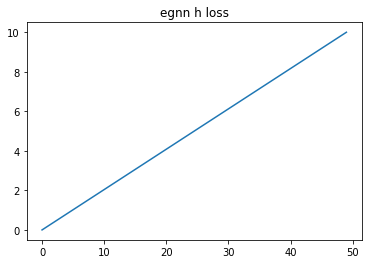

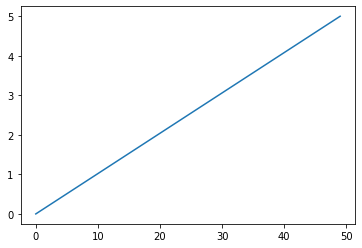

In [ ]:
plt.figure()
plt.plot(l)
plt.title('egnn h loss')
plt.figure()
plt.plot(m)

In [ ]:
l

[0.0]